imports

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

Carga y Preparación Inicial del Dataset

Archivo corregido y guardado como: data/AirQualityNuevo.csv

Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 9471 entries, ('10/03/2004', '18.00.00', 2.0, 6.0, 1360.0) to (nan, nan, nan, nan, nan)
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   float64
 1   Time           9357 non-null   float64
 2   CO(GT)         9357 non-null   float64
 3   PT08.S1(CO)    9357 non-null   float64
 4   NMHC(GT)       9357 non-null   float64
 5   C6H6(GT)       9357 non-null   float64
 6   PT08.S2(NMHC)  9357 non-null   float64
 7   NOx(GT)        9357 non-null   float64
 8   PT08.S3(NOx)   9357 non-null   float64
 9   NO2(GT)        9357 non-null   float64
 10  PT08.S4(NO2)   9357 non-null   float64
 11  PT08.S5(O3)    9296 non-null   float64
 12  T              8991 non-null   float64
 13  RH             8991 non-null   float64
 14  AH             6915 non-null   f

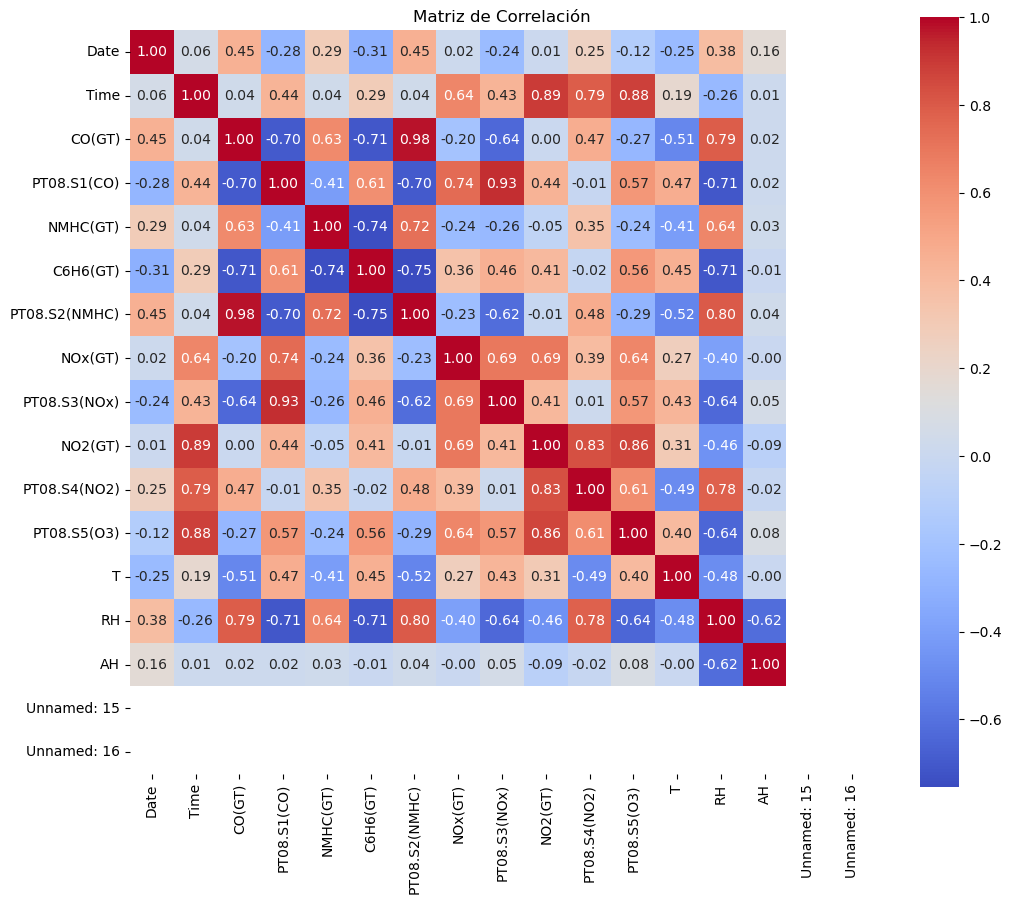

In [3]:
import pandas as pd

# Ruta del archivo original
ruta_archivo = 'data/AirQuality.csv'
ruta_nueva = 'data/AirQualityNuevo.csv'

# Leer el archivo y reemplazar delimitadores inconsistentes por comas
with open(ruta_archivo, 'r') as archivo:
    contenido = archivo.read()

# Reemplazar delimitadores inconsistentes: convertir ';' y tabulaciones a ','
contenido = contenido.replace('\t', ',').replace(';', ',')

# Guardar el contenido corregido en un nuevo archivo
with open(ruta_nueva, 'w') as archivo_corregido:
    archivo_corregido.write(contenido)

print("Archivo corregido y guardado como:", ruta_nueva)

# Cargar el archivo corregido en un DataFrame
df = pd.read_csv(ruta_nueva)

# Mostrar información básica del DataFrame
print("\nInformación del DataFrame:")
print(df.info())

print("\nPrimeras filas del DataFrame:")
print(df.head())
df.describe()

# Matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Matriz de Correlación")
plt.show()

Limpieza de Datos

In [4]:
# Eliminar columnas innecesarias o problematicas 
df = df.drop(columns=['Unnamed: 15', 'Unnamed: 16', 'Date'], errors='ignore')

df.reset_index(drop=True, inplace=True)

# Eliminar filas con valores faltantes
df_cleaned = df.dropna()  # Elimina filas con NaN
df_cleaned = df.fillna(0)  # Rellena NaN con 0

df_cleaned.info()
df_cleaned.head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Time           9471 non-null   float64
 1   CO(GT)         9471 non-null   float64
 2   PT08.S1(CO)    9471 non-null   float64
 3   NMHC(GT)       9471 non-null   float64
 4   C6H6(GT)       9471 non-null   float64
 5   PT08.S2(NMHC)  9471 non-null   float64
 6   NOx(GT)        9471 non-null   float64
 7   PT08.S3(NOx)   9471 non-null   float64
 8   NO2(GT)        9471 non-null   float64
 9   PT08.S4(NO2)   9471 non-null   float64
 10  PT08.S5(O3)    9471 non-null   float64
 11  T              9471 non-null   float64
 12  RH             9471 non-null   float64
 13  AH             9471 non-null   float64
dtypes: float64(14)
memory usage: 1.0 MB


,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,11.0,9.0,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.0,6.0,48.0,9.0,0.0,7578.0
1,4.0,955.0,103.0,1174.0,92.0,1559.0,972.0,13.0,3.0,47.0,7.0,0.0,7255.0,0.0
2,9.0,0.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.0,9.0,54.0,0.0,0.0,7502.0
3,9.0,2.0,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,0.0,60.0,0.0,0.0,7867.0
4,6.0,5.0,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.0,2.0,59.0,6.0,0.0,7888.0
5,4.0,7.0,750.0,89.0,1337.0,96.0,1393.0,949.0,11.0,2.0,59.0,2.0,0.0,7848.0
6,3.0,6.0,690.0,62.0,1462.0,77.0,1333.0,733.0,11.0,3.0,56.0,8.0,0.0,7603.0
7,3.0,672.0,62.0,1453.0,76.0,1333.0,730.0,10.0,7.0,60.0,0.0,0.0,7702.0,0.0
8,2.0,3.0,609.0,45.0,1579.0,60.0,1276.0,620.0,10.0,7.0,59.0,7.0,0.0,7648.0
9,1.0,7.0,561.0,-200.0,1705.0,-200.0,1235.0,501.0,10.0,3.0,60.0,2.0,0.0,7517.0


Volvemos a mirar la correlación entre variables 

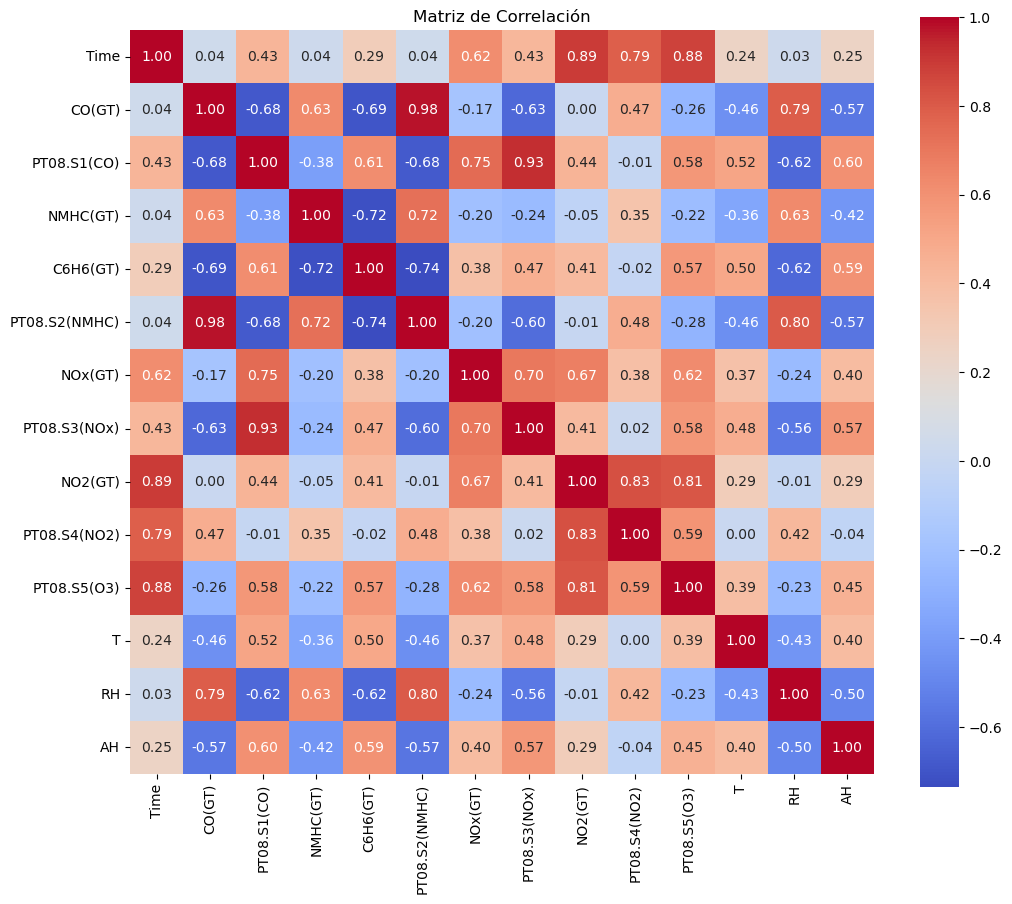

In [5]:
# Matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(df_cleaned.corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Matriz de Correlación")
plt.show()

definir features y target 

predictors:
T: Temperatura ambiental medida en °C.
RH: Humedad relativa en el ambiente, expresada como un porcentaje.
AH: Humedad absoluta, una medida de la cantidad de vapor de agua en el aire.
PT08.S5(O3): Señal del sensor para ozono (O3), utilizado para medir la concentración de este gas.
PT08.S1(CO): Señal del sensor para monóxido de carbono (CO), utilizada para estimar su concentración.
PT08.S2(NMHC): Señal del sensor para compuestos orgánicos no metánicos (NMHC), representando su nivel en el aire.

targets:
CO(GT): Monóxido de carbono.
NMHC(GT): Compuestos orgánicos no metánicos.
C6H6(GT): Benceno.
NOx(GT): Óxidos de nitrógeno (una combinación de NO y NO2).
NO2(GT): Dióxido de nitrógeno.

In [6]:
# Definir predictores y objetivos
predictors = ['T', 'RH', 'AH']
targets = ['CO(GT)', 'NOx(GT)', 'NO2(GT)', 'C6H6(GT)', 'NMHC(GT)']


X = df_cleaned[predictors]
y = df_cleaned[targets]


MinMaxScaler: Es un método de escalado que transforma los valores de las características al rango [0, 1] (o a otro rango definido), manteniendo las relaciones proporcionales de los datos

In [7]:
# normalización
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
# Separar datos en entrenamiento y validación
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

definir los modelos y sus hiperparametros 

In [8]:
from sklearn.model_selection import GridSearchCV

# Definir modelos y sus hiperparámetros
param_grids = {
    'Linear Regression': {
        'model': LinearRegression(),
        'params': {}
    },
    'Decision Tree': {
        'model': DecisionTreeRegressor(),
        'params': {
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10]
        }
    },
    'Random Forest': {
        'model': RandomForestRegressor(),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10]
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingRegressor(),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7]
        }
    },
    'Support Vector Regressor': {
        'model': SVR(),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf'],
            'epsilon': [0.01, 0.1, 1]
        }
    }
}

results = {}


Entrenar y evaluar cada modelo por variable objetivo

In [9]:

# Entrenar y evaluar cada modelo por variable objetivo
for target in targets:
    print(f"\nOptimización de hiperparámetros para el objetivo: {target}")
    y_train_target = y_train[target]
    y_test_target = y_test[target]

    results[target] = {}
    
    for name, config in param_grids.items():
        model = config['model']
        params = config['params']
        
        # Configurar GridSearchCV
        grid_search = GridSearchCV(estimator=model, param_grid=params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(X_train, y_train_target)
        
        # Mejor modelo y evaluación
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)
        mse = mean_squared_error(y_test_target, y_pred)
        r2 = r2_score(y_test_target, y_pred)
        
        # Guardar resultados
        results[target][name] = {
            'Best Params': grid_search.best_params_,
            'MSE': mse,
            'R2': r2
        }
        print(f"{name} mejor MSE: {mse:.4f}, R2: {r2:.4f}, Hiperparámetros: {grid_search.best_params_}")




Optimización de hiperparámetros para el objetivo: CO(GT)
Linear Regression mejor MSE: 48970.9561, R2: 0.6757, Hiperparámetros: {}
Decision Tree mejor MSE: 16417.7568, R2: 0.8913, Hiperparámetros: {'max_depth': 10, 'min_samples_split': 10}
Random Forest mejor MSE: 14163.4901, R2: 0.9062, Hiperparámetros: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}
Gradient Boosting mejor MSE: 13840.6392, R2: 0.9084, Hiperparámetros: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Support Vector Regressor mejor MSE: 31874.0026, R2: 0.7890, Hiperparámetros: {'C': 10, 'epsilon': 1, 'kernel': 'rbf'}

Optimización de hiperparámetros para el objetivo: NOx(GT)
Linear Regression mejor MSE: 204764.0697, R2: 0.2077, Hiperparámetros: {}
Decision Tree mejor MSE: 82280.4138, R2: 0.6816, Hiperparámetros: {'max_depth': 10, 'min_samples_split': 10}
Random Forest mejor MSE: 76411.8852, R2: 0.7044, Hiperparámetros: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}
Gradient Bo

ver resultados 

Resultados Finales:
      Target                     Model            MSE        R2  \
0     CO(GT)         Linear Regression   48970.956058  0.675746   
1     CO(GT)             Decision Tree   16417.756787  0.891292   
2     CO(GT)             Random Forest   14163.490096  0.906219   
3     CO(GT)         Gradient Boosting   13840.639179  0.908356   
4     CO(GT)  Support Vector Regressor   31874.002630  0.788951   
5    NOx(GT)         Linear Regression  204764.069729  0.207747   
6    NOx(GT)             Decision Tree   82280.413784  0.681649   
7    NOx(GT)             Random Forest   76411.885201  0.704355   
8    NOx(GT)         Gradient Boosting   75075.322403  0.709526   
9    NOx(GT)  Support Vector Regressor  161594.263333  0.374775   
10   NO2(GT)         Linear Regression    1405.093710  0.162828   
11   NO2(GT)             Decision Tree     390.225966  0.767498   
12   NO2(GT)             Random Forest     385.750277  0.770165   
13   NO2(GT)         Gradient Boosting    

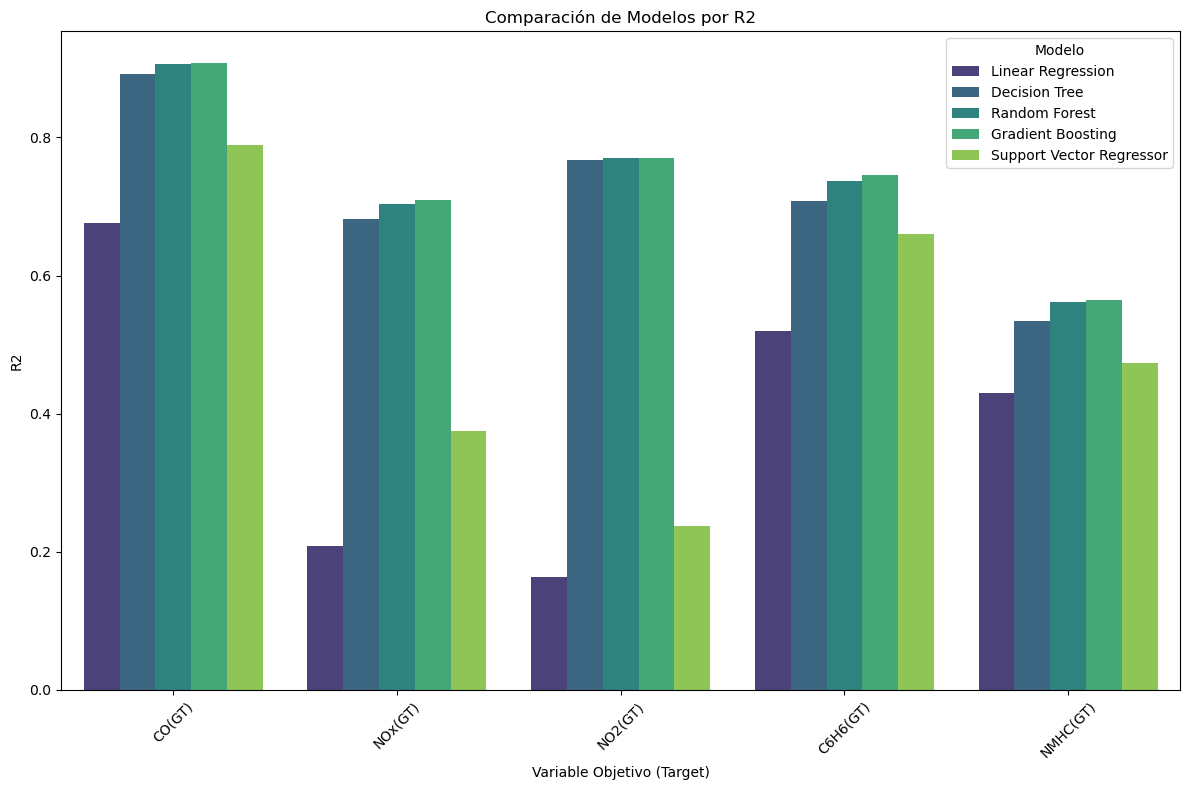

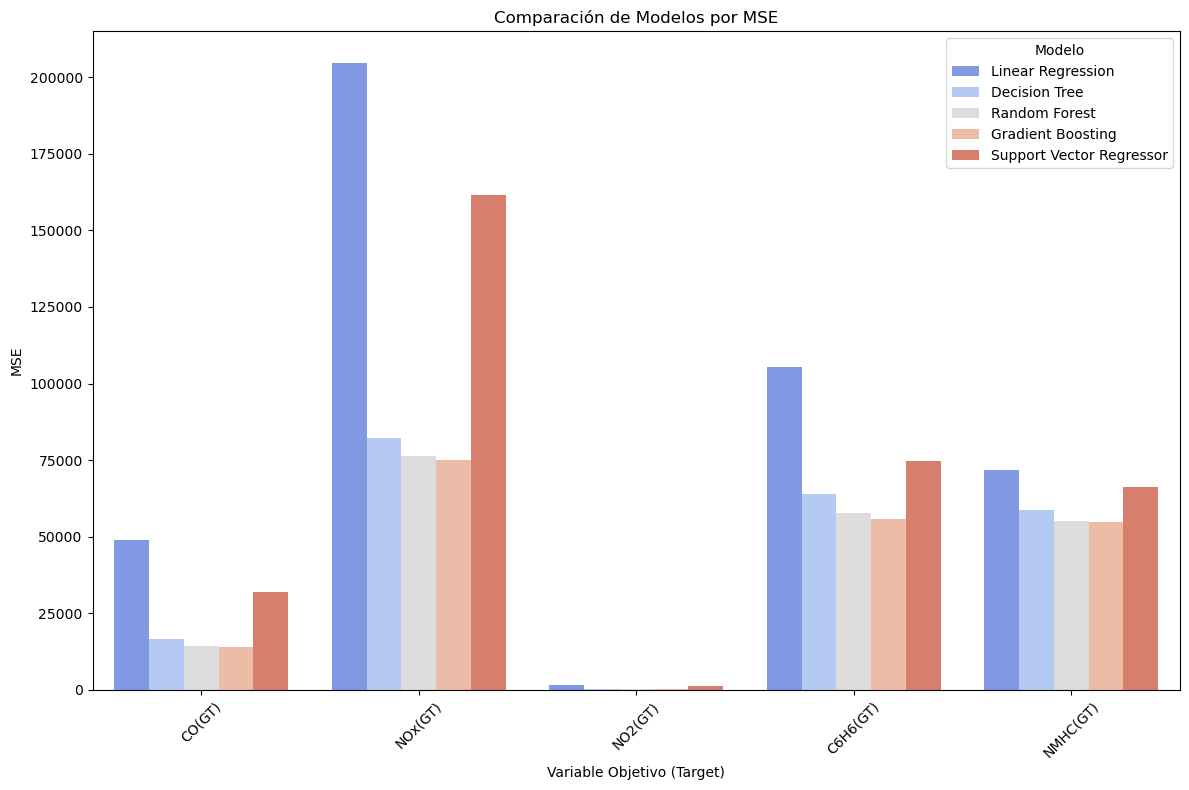

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Crear un DataFrame con los resultados finales
rows = []
for target, metrics in results.items():
    for name, scores in metrics.items():
        rows.append({
            'Target': target,
            'Model': name,
            'MSE': scores['MSE'],
            'R2': scores['R2'],
            'Best Params': scores['Best Params']
        })

results_df = pd.DataFrame(rows)

# Mostrar la tabla de resultados
print("Resultados Finales:")
print(results_df)

# Visualizar los resultados con un gráfico de barras
plt.figure(figsize=(12, 8))
sns.barplot(data=results_df, x='Target', y='R2', hue='Model', palette='viridis')
plt.title("Comparación de Modelos por R2")
plt.ylabel("R2")
plt.xlabel("Variable Objetivo (Target)")
plt.legend(title="Modelo")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualizar los MSE en otro gráfico
plt.figure(figsize=(12, 8))
sns.barplot(data=results_df, x='Target', y='MSE', hue='Model', palette='coolwarm')
plt.title("Comparación de Modelos por MSE")
plt.ylabel("MSE")
plt.xlabel("Variable Objetivo (Target)")
plt.legend(title="Modelo")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


mirar sobre ajuste 

Epoch 1/30


c:\Users\Ikasle\miniconda3\envs\TODO_py310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8616 - loss: 0.4693 - val_accuracy: 0.9580 - val_loss: 0.1367
Epoch 2/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9647 - loss: 0.1186 - val_accuracy: 0.9639 - val_loss: 0.1122
Epoch 3/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9785 - loss: 0.0743 - val_accuracy: 0.9707 - val_loss: 0.0997
Epoch 4/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9825 - loss: 0.0548 - val_accuracy: 0.9735 - val_loss: 0.0890
Epoch 5/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9856 - loss: 0.0442 - val_accuracy: 0.9759 - val_loss: 0.0870
Epoch 6/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9889 - loss: 0.0364 - val_accuracy: 0.9757 - val_loss: 0.0923
Epoch 7/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9908 - loss: 0.0274 - val_accuracy: 0.9748 - val_loss: 0.0910
Epoch 8/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9941 - loss: 0.0202 - val_accurac

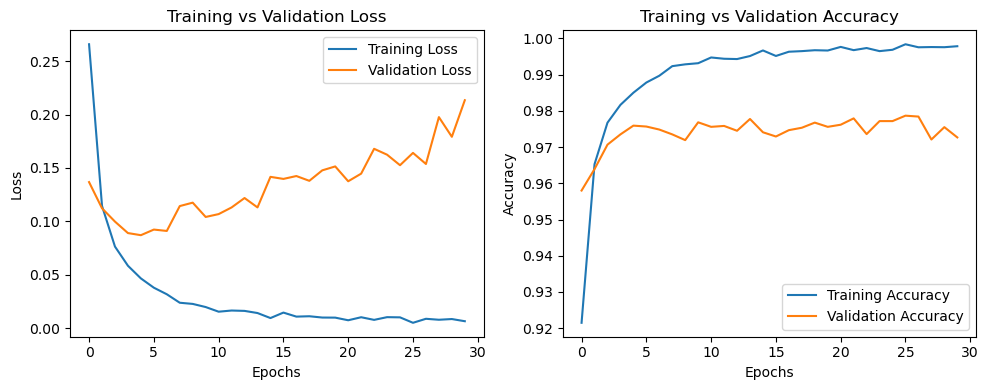

In [11]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# 1. Cargar los datos
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train.reshape(-1, 28*28) / 255.0, x_test.reshape(-1, 28*28) / 255.0
y_train, y_test = to_categorical(y_train), to_categorical(y_test)

# 2. Crear un modelo simple
model = Sequential([
    Dense(128, activation='relu', input_shape=(28*28,)),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

# 3. Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 4. Entrenar el modelo con validación
history = model.fit(
    x_train, y_train,
    validation_split=0.2,  # Usar 20% de datos para validación
    epochs=30,
    batch_size=32
)

# 5. Graficar métricas de rendimiento
def plot_metrics(history):
    # Pérdida (Loss)
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training vs Validation Loss')

    # Precisión (Accuracy)
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training vs Validation Accuracy')

    plt.tight_layout()
    plt.show()

# Llamar a la función para graficar
plot_metrics(history)
